# Graph Neural Networks tutorial
*Nikola Jovanović (njovanovic@ethz.ch)*


**Prerequisites:**
- GNN basics (Petar's talk)
- PyTorch

**Outline:**
- [Warmup] Graphs, networkx
- [Part 1] Implementing GCN and GAT 
- [Part 2] 3 types of problems in PyTorch Geometric
- [Bonus] Intro to graph adversarial attacks

## [Warmup] Graphs, networkx

### Recap of graph fundamentals

A **graph** is a pair $\mathcal{G} = (\mathcal{V}, \mathcal{E})$, where $\mathcal{V}$ is the set of $N$ **vertices** (nodes), and $\mathcal{E}$ is the set of graph **edges** (links), i.e., pairs $(u,v)$ representing a connection between two vertices $u,v \in \mathcal{V}$. We will here consider **undirected** graphs, meaning that $(u,v) \in \mathcal{E} \implies (v,u) \in \mathcal{E}$.

There are two common ways to represent $\mathcal{E}$: 
1. As an **adjacency matrix**: a binary square matrix $A$ of size $N \times N$, where $A_{u,v}=1$ iff there is a connection between nodes $u$ and $v$.
2. As an **adjacency list**: a list of ordered pairs $(u,v)$.


### NetworkX





NetworkX is a Python library focused on graphs and networks, offering a large number of useful methods, including visualization which we will use several times in this colab.

Let's install the library and proceed to create and draw a simple graph:

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx 

# Create a simple graph
G = nx.Graph() # Use DiGraph for directed graphs
G.add_nodes_from([1,2,3,4])
G.add_edges_from([(1,2), (1,3), (1,4), (3,4)])

# Print basic info
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
print(f'Graph G with {nb_nodes} nodes and {nb_edges} edges')
print(f'Adjacency list: {G.edges}')
print(f'Adjacency matrix (symmetric):')
A = nx.adjacency_matrix(G) # Returns a sparse matrix
print(A.todense())
print(f'Degree of node 1: {G.degree(1)}')

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue')

There is a large collection of graph algorithms and graph generators for both known graphs and random graph models. We will show one example, for more see [the documentation](https://networkx.org/documentation/stable/reference/index.html).

In [ ]:
# Shortest paths on an Erdos Renyi graph
G = nx.erdos_renyi_graph(n=10, p=0.5)
nx.draw(G, with_labels=True, node_color='lightblue')

paths = nx.single_source_shortest_path(G, 0)
print('Shortest paths from node 0:')
import pprint 
pprint.pprint(paths)

## [Part 1] Implementing GCN and GAT

Recall the high-level perspective on the way GNNs are applied:



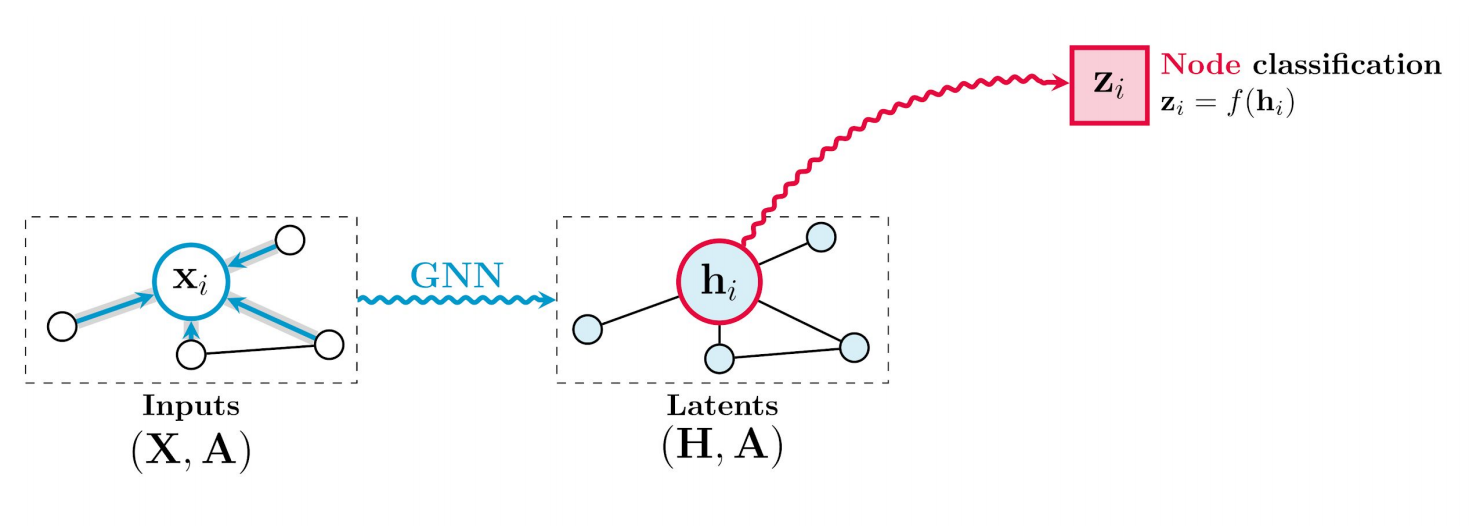

We start from a graph with adjacency matrix $A$ and node features $x_i$. Using a GNN, for each node we compute (based on its neighborhood) a latent feature vector $h_i$. With these we can attempt to solve various tasks, where for now we focus on **node classification** (the other two common tasks will be shown in Part 2 of this tutorial).

In node classification, we are most often given a single graph, where only a portion of nodes is labeled. Using these nodes as a signal for training, our goal is to successfully classify the remaining nodes. To this end, we look at previously computed node latent vectors in isolation, and learn a classifier $z_i = f(h_i)$.




### Cora dataset


For this problem we will use **Cora**, a citation graph containing 2708 scientific publications. For each publication we have a 1433-dimensional feature vector, which is a bag-of-words representation (with a small, fixed dictionary) of the paper text. The edges in this graph represent citations, and are commonly treated as undirected. The goal is to classify each paper into one of seven classes (topics).

We will load and inspect the Cora dataset using the PyTorch Geometric library (which we will extensively use in Part 2):

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

In [ ]:
import torch_geometric
from torch_geometric.utils import to_dense_adj

# Fetch the Dataset object
dataset = torch_geometric.datasets.Planetoid(root='/', name='Cora')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()

# One graph is one Data object, with the following attributes:
#   edge_index:     the adjacency list of shape [2, num_edges] (COO format)
#   x:              the feature matrix of shape [num_nodes, num_features]
#   y:              node labels of shape [num_nodes]
#   train_mask:     a boolean mask of shape [num_nodes], indicating the train set
#                   (similarly for val_mask and test_mask)
data = dataset[0]
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print()

print('Train mask:')
print(data.train_mask)
print('Edge index:')
print(data.edge_index)
print('Corresponding adjacency matrix (using to_dense_adj):')
print(to_dense_adj(data.edge_index))
print()

# Some more utility functions on a Data object 
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

*Note*: The Cora dataset (similarly for MUTAG which we will use later) is great for rapid prototyping and sanity-checking of models. However, it is widely considered to be oversaturated, and it is advised to use higher quality datasets (such as [OGB](https://ogb.stanford.edu/) or [benchmarking-gnns](https://github.com/graphdeeplearning/benchmarking-gnns)) whenever possible.


### Towards Graph Convolutional Network (GCN)

With our dataset ready, we can start working on our model. In all the examples in this section we will use the same 2-layer network. Starting from a simple propagation rule, **sum-pool**, we will keep improving the base layer we use until we reach the one of GCN. 

Given as inputs $A$, the $N \times N$ adjacency matrix, and $H$, the $N \times F$ feature matrix, where each node has an $F$-dimensional feature vector, the propagation rule of sum-pool is as follows:
$$ H' = \sigma(AHW) $$
Here, $W$ is a learnable weight matrix of shape $F \times F'$, $\sigma(\cdot)$ is a non-linear activation function (e.g. ReLU), and H' holds the output node features ($N \times F'$).

Focusing on node $i$, we get the following equation for its features (where $\mathcal{N}(i)$ is the set of its neighbors):
$$ h'_i = \sigma \left( \sum_{j \in \mathcal{N}(i)} W^T h_j  \right) $$

In other words, we simply sum up the transformed features of all neighbors. Let's implement this layer in a class extending `torch.nn.Module`.

*Note*: we assume that $A$ was preprocessed to contain all self-edges (as otherwise a node would not depend on its own features which is clearly undesirable).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
class SumPoolLayer(torch.nn.Module):
    # sz_in=F, sz_out=F'
    # we will apply the nonlinearity later
    def __init__(self, sz_in, sz_out):
        super().__init__()
        self.W = nn.Parameter(torch.empty(size=(sz_in, sz_out)))
        nn.init.xavier_uniform_(self.W.data)
    
    # Propagation rule: H' = sigma(AHW) 
    def forward(self, fts, adj):
        new_fts = torch.mm(fts, self.W)
        ret_fts = torch.mm(adj, new_fts)
        return ret_fts

Using this layer as the main building block, let's build our network:

In [ ]:
class GNNModel(torch.nn.Module):
    # We provide layer_type as the class to use for each of num_layers layers
    def __init__(self, layer_type, num_layers=2, sz_in=1433, sz_hid=32, sz_out=7):
        super().__init__()
        layers = []

        # sz_in -> sz_hid -> ... -> sz_hid -> sz_out
        layers.append(layer_type(sz_in, sz_hid))
        layers.append(nn.ReLU())
        for _ in range(num_layers-2):
            layers.append(layer_type(sz_hid, sz_hid))
            layers.append(nn.ReLU())
        layers.append(layer_type(sz_hid, sz_out))

        self.layers = nn.ModuleList(layers)
    
    def forward(self, fts, adj):
        for l in self.layers:
            if isinstance(l, nn.ReLU):
                fts = l(fts)
            else:
                fts = l(fts, adj)
        return fts

Finally, let's write a training function and use it to test our implementation:

In [ ]:
# Train the given model on the given graph for num_epochs
def train(model, data, num_epochs, use_edge_index=False):
    if not use_edge_index:
        # Create the adjacency matrix
        # Important: add self-edges so a node depends on itself
        adj = to_dense_adj(data.edge_index)[0]
        adj += torch.eye(adj.shape[0])
    else:
        # Directly use edge_index, ignore this branch for now
        adj = data.edge_index

    # Set up the loss and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # A utility function to compute the accuracy
    def get_acc(outs, y, mask):
        return (outs[mask].argmax(dim=1) == y[mask]).sum().float() / mask.sum()

    best_acc_val = -1
    for epoch in range(num_epochs):
        # Zero grads -> forward pass -> compute loss -> backprop
        optimizer.zero_grad()
        outs = model(data.x, adj)
        loss = loss_fn(outs[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Compute accuracies, print only if this is the best result so far
        acc_val = get_acc(outs, data.y, data.val_mask)
        acc_test = get_acc(outs, data.y, data.test_mask)
        if acc_val > best_acc_val:
            best_acc_val = acc_val
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Val: {acc_val:.3f} | Test: {acc_test:.3f}')

Testing sum-pool:

In [ ]:
model = GNNModel(SumPoolLayer)
train(model, data, num_epochs=100)

We observe ~75% test accuracy. A useful sanity check for any graph model is to use a simple MLP (i.e., ignore the adjacency matrix entirely). If the results are comparable, utilizing the edge information on this problem may not be useful at all. Let's test this:

In [ ]:
class LinearLayer(torch.nn.Module):
    def __init__(self, sz_in, sz_out):
        super().__init__()
        self.W = nn.Parameter(torch.empty(size=(sz_in, sz_out)))
        nn.init.xavier_uniform_(self.W.data)
    
    def forward(self, fts, adj):
        # Simple linear layer application
        new_fts = torch.mm(fts, self.W)
        return new_fts

model = GNNModel(LinearLayer)
train(model, data, num_epochs=100)

We get ~50% test accuracy, significantly worse than our previous run, confirming that GNNs are useful on this task.

However, one limitation of the sum-pool approach is that, as we are simply summing up feature vectors, repeated applications could greatly increase the scale of the features. A way to solve this is to normalize the adjacency matrix by multiplying it by the inverse of the diagonal degree matrix $D$ ($D_{ii}$ represents the degree of node $i$), which effectively divides each row by the degree of the corresponding node. This leads us to the **mean-pool** update rule:

$$ H' = \sigma(D^{-1}AHW) $$

Instead of a sum, each node now has the average of the neighbors' transformed features:
$$ h'_i = \sigma \left( \sum_{j \in \mathcal{N}(i)} \frac{1}{|\mathcal{N}(i)|} W^T h_j \right) $$

Let's implement this layer. We should observe slightly better results this time, closer to 80% test accuracy.

In [ ]:
class MeanPoolLayer(torch.nn.Module):
    def __init__(self, sz_in, sz_out):
        super().__init__()
        self.W = nn.Parameter(torch.empty(size=(sz_in, sz_out)))
        nn.init.xavier_uniform_(self.W.data)
    
    def forward(self, fts, adj):
        new_fts = torch.mm(fts, self.W)
        deg = adj.sum(axis=1) # New!
        ret_fts = torch.mm(adj/deg, new_fts) # New!
        return ret_fts

model = GNNModel(MeanPoolLayer)
train(model, data, num_epochs=100)

Mean-pool is often a good choice. However, there are other ways to solve the issues of sum-pool, such as using **symmetric normalization** -- multiplying $A$ by $D^{-1/2}$ on both sides:

$$ H' = \sigma(D^{-1/2}AD^{-1/2}HW) $$

This is exactly the propagation rule used by **GCN**, the most popular graph convolutional layer. Consider the node-wise formulation, fixing the node $i$ as the "receiver" node:

$$ h'_i = \sigma \left( \sum_{j \in \mathcal{N}(i)} \frac{1}{\sqrt{|\mathcal{N}(i)|} \sqrt{|\mathcal{N}(j)| }} W^T h_j \right) $$

We observe that, the coefficient used for the transformed feature vector of some sender node $j$ is now dependent on node $j$ itself. Namely, the contributions of high-degree nodes will be deemed less significant, while the largest coefficient will be assigned to a node whose only connection is the receiver node $i$. 

Let's implement and test this. In this setting we should get similar results to mean-pool.


In [ ]:
class GCNLayer(torch.nn.Module):
    def __init__(self, sz_in, sz_out):
        super().__init__()
        self.W = nn.Parameter(torch.empty(size=(sz_in, sz_out)))
        nn.init.xavier_uniform_(self.W.data)
    
    def forward(self, fts, adj):
        new_fts = torch.mm(fts, self.W)

        deg = adj.sum(axis=1)
        deg_inv_half = torch.diag(1.0 / torch.sqrt(deg)) # New!
        adj_norm = deg_inv_half @ adj @ deg_inv_half # New!
        
        ret_fts = torch.mm(adj_norm, new_fts) # New!
        return ret_fts

model = GNNModel(GCNLayer)
train(model, data, num_epochs=100)

# Slow! adj->adj_norm step should be done in preprocessing

### Graph Attention Network (GAT)

While the coefficents in GCN were dependent on both nodes, they were still constant. If we relax this to make them dependent on the current input, we get **attention**. Namely, our update rule for one node will now be:
$$ h'_i = \sigma \left( \sum_{j \in \mathcal{N}(i)} \alpha_{ij} W^T h_j \right) $$
where $\alpha_{ij}$ are the **attention coefficients**, determining how much of the incoming "message" from node $j$ should node $i$ take in. 

To compute $\alpha_{ij}$ we apply a one-layer MLP $a$ on concatenated "messages" $W^Th_i$ and $W^Th_j$ with LeakyReLU activation:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[W^T h_i||W^T h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}(i)} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[W^T h_i||W^T h_k\right]\right)\right)}$$

Softmax is applied as normalization, s.t. the sum of coefficients each node uses to receive messages is the same irrespective of the size of the neighborhood.


To stabilize learning, similar to the original Transformer paper, GAT employs **multi-head attention**: each GAT layer has $K$ independent replicas, whose results are simply concatenated to obtain final feature vectors, or averaged if we are at the output layer. Here is a visualization:

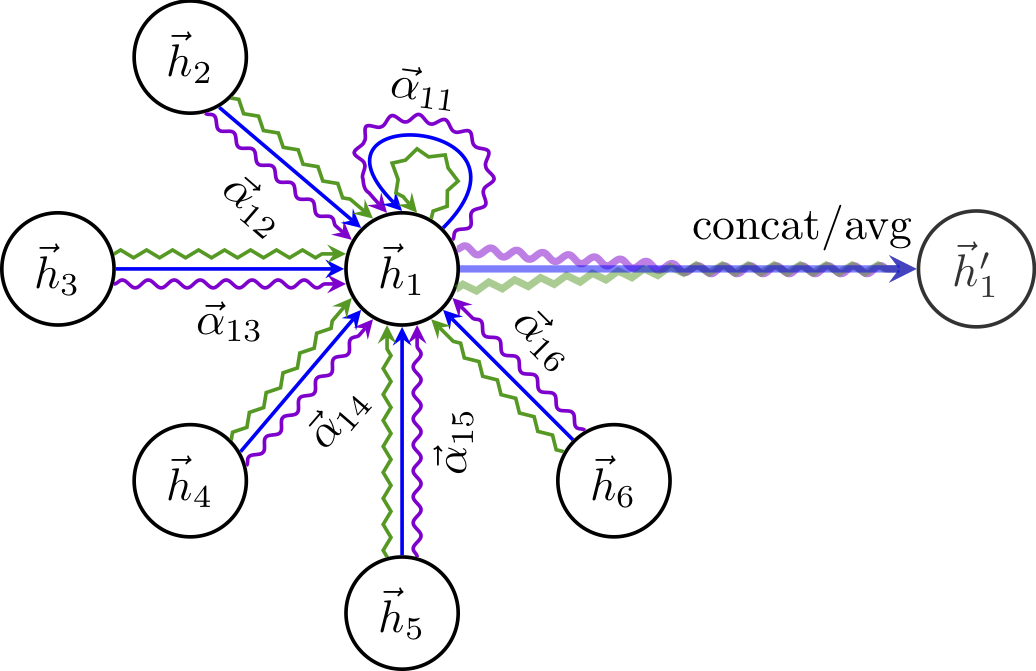

Let's implement GAT. We will start from one **attention head**:

In [ ]:
class GATAttentionHead(torch.nn.Module):
    def __init__(self, sz_in, sz_out):
        super().__init__()
        self.sz_out = sz_out
        
        # To linearly transform features
        # Initialization params from the original paper
        self.W = nn.Parameter(torch.empty(size=(sz_in, sz_out))) # F X F'
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        # To calculate attention coefficients
        # Initialization params from the original paper
        self.a = nn.Parameter(torch.empty(size=(2*sz_out, 1))) # 2F' X 1
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leaky_relu = nn.LeakyReLU(0.2)
    
    def forward(self, fts, adj):
        # Apply the linear transformation
        new_fts = torch.mm(fts, self.W)

        # To be memory efficient, we want to compute the
        # attention coefficients only for edges in the graph

        # Concatenate new feature vectors for each present edge
        edges = adj.nonzero(as_tuple=True) # ([u1, u2, ...], [v1, v2, ....])
        a_input = torch.cat([new_fts[edges[0]], new_fts[edges[1]]], dim=1) # |E| x 2F'

        # Apply the 1-layer MLP a to get the unnormalized scores
        e = self.leaky_relu(torch.mm(a_input, self.a).squeeze())

        # Place the scores in an NxN matrix
        # Set all other scores to a very small value for softmax
        e_full = torch.full_like(adj, -9e15)
        e_full[edges] = e

        # Compute the attention coefficients (will be 0 for non-edges)
        alphas = F.softmax(e_full, dim=1)

        # Finally use the alphas to weight the incoming features
        ret_fts = torch.matmul(alphas, new_fts)
        return ret_fts

It is simple to extend this to a multi-head GAT layer:

In [ ]:
class GATLayer(torch.nn.Module):
    def __init__(self, num_heads, sz_in, sz_out, agg):
        super().__init__()

        # Aggregation ('concat', or 'mean' for the last layer)
        self.agg = agg

        # Independent attention heads
        heads = []
        for _ in range(num_heads):
            heads.append(GATAttentionHead(sz_in, sz_out))
        self.heads = nn.ModuleList(heads)

    def forward(self, fts, adj):
        # Apply all heads
        outs = [head(fts, adj) for head in self.heads]
        if self.agg == 'concat':
            # Apply the activation and concatenate
            # N x num_heads*sz_out
            return torch.cat([F.elu(out) for out in outs], dim=1)
        else:
            # No activation, average (assumes we average only at the end)
            # N x sz_out
            return torch.mean(torch.stack(outs), dim=0)

We repeat the GNNModel class from before with slight changes for GAT:

In [ ]:
class GATModel(torch.nn.Module):
    # We provide layer_type as the class to use for each of num_layers layers
    def __init__(self, num_layers=2, num_heads=8, sz_in=1433, sz_hid=32, sz_out=7):
        super().__init__()
        layers = []

        # sz_in -> sz_hid -> ... -> sz_hid -> sz_out
        layers.append(GATLayer(num_heads, sz_in, sz_hid, agg='concat'))
        for _ in range(num_layers-2):
            layers.append(GATLayer(num_heads, num_heads*sz_hid, sz_hid, agg='concat'))
        layers.append(GATLayer(num_heads, num_heads*sz_hid, sz_out, agg='mean'))

        self.layers = nn.ModuleList(layers)
    
    def forward(self, fts, adj):
        for l in self.layers:
            fts = l(fts, adj)
        return fts

As before, we test our model:

In [ ]:
model = GATModel()
train(model, data, num_epochs=100)

As with GCN, we observe around 80% accuracy. This concludes the first part of the tutorial.

## [Part 2] 3 types of problems in PyTorch Geometric

Now let's do the same thing using the PyTorch Geometric (PyG) library. 

`torch_geometric.nn` has various GNN layers ready for use, and we can simply plug them in directly instead of our layer classes, and get the same results. The only minor change is that we will set `use_edge_index=True` as `torch_geometric.nn` layers operate directly on the adjacency lists (and take care of preprocessing such as self-loop insertion).

In [ ]:
model = GNNModel(torch_geometric.nn.GCNConv)
train(model, data, num_epochs=100, use_edge_index=True)
cora, cora_gcn = data, model # Ignore for now

In [ ]:
model = GNNModel(torch_geometric.nn.GATConv)  # Note: 1 head
train(model, data, num_epochs=100, use_edge_index=True)

However, we only focused on node classification so far, one of 3 common types of problems:

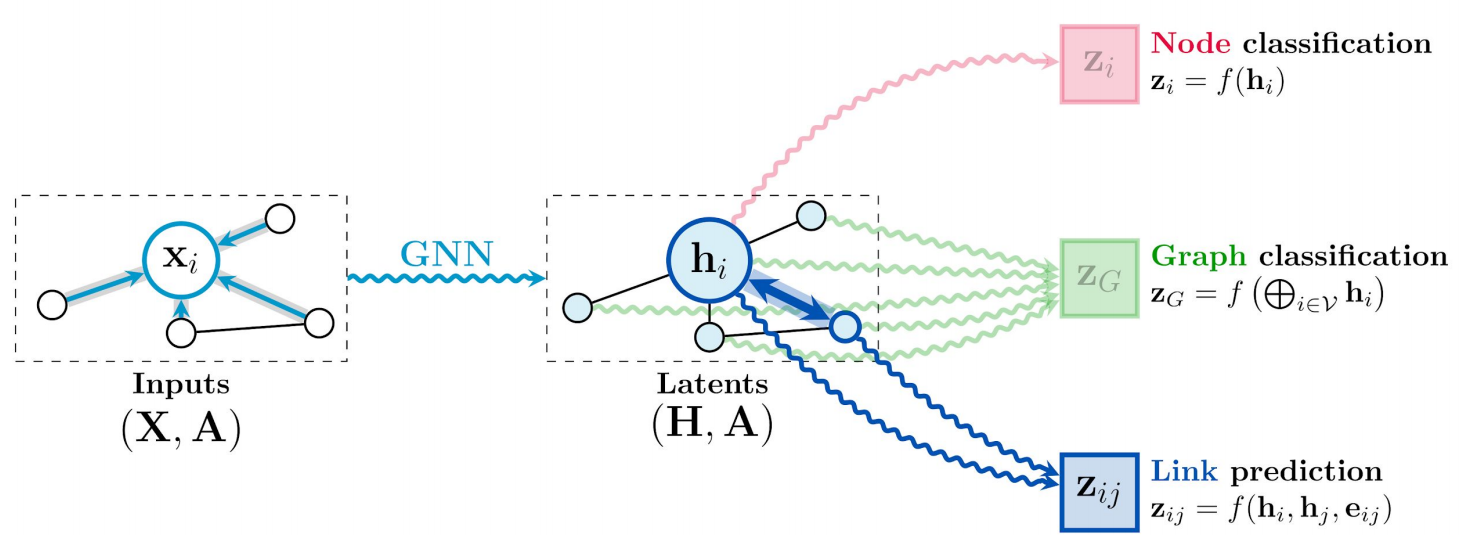

In this part we will also give an example of other two types: **graph classification** and **link prediction**.

### Graph classification with MUTAG

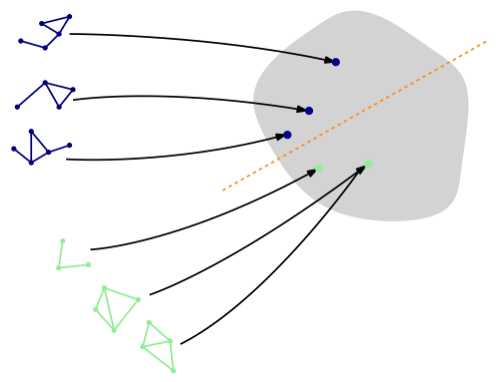

We will demonstrate how to apply GNNs for graph classification. The main difference from our previous setup is that instead of observing individual node latents, we are now attempting to summarize them into one vector, representative of the entire graph, that we use to predict the class of this graph.

We will do this on one of the most common tasks of this type -- **molecular property prediction**, where molecules are represented as graphs. Nodes correspond to atoms, and edges represent the bonds between them.

We will use the **MUTAG** dataset, a common dataset from the [TUDatasets](https://chrsmrrs.github.io/datasets/) collection. Let's load and inspect it:

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='./', name='MUTAG')

print({dataset})
print(f'Number of graphs: {len(dataset)}') # New!
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print()

# Inspect the first graph
print('First graph:')
data = dataset[0]
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

We see that there are 188 graphs, to be classified in one of 2 classes, representing "their mutagenic effect on a specific gram negative bacterium". Node features represent the 1-hot encoding of the atom type (0=C, 1=N, 2=O, 3=F, 4=I, 5=Cl, 6=Br). Edge features (`edge_attr`) represent the bond type, which we will here ignore.

Let's split the dataset to use the first 150 graphs as the training set (and the rest as the test set) and plot one of them using networkx.

In [ ]:
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

data = train_dataset[0]

from torch_geometric.utils import to_networkx

# Color the nodes based on the atom type
cmap = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd']
colors = [cmap[torch.argmax(ft)] for ft in data.x]

nx.draw(to_networkx(data), with_labels=True, node_color=colors)

Recall that for node classification we had one graph that we repeatedly forwarded through the network. Now that we have more graphs, it is natural to think about **batching**, to achieve parallelization and speed up the training process. However, our graphs are of different sizes:


In [ ]:
sizes = [data.num_nodes for data in train_dataset]
print(sizes)

To resolve this problem, we would usually (e.g., in images) simply pad the smaller inputs with dummy values such that all inputs end up of the same size, and then group them to form a single batch.

However, for GNNs this is not the most efficient approach. Instead, PyTorch Geometric does the following: 

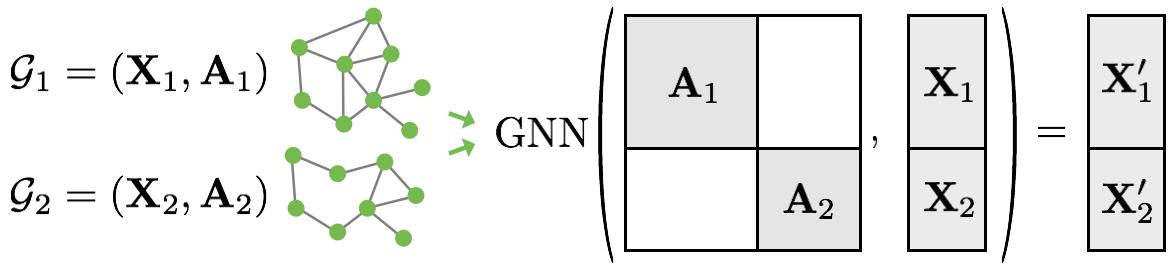

Namely, we stack the adjacency matrix diagonally (i.e., concatenate adjacency lists -- note that this does not waste memory), and simply concatenate node features, to obtain one large graph with several components. It is easy to see that this works with no changes to our network, as adding components this way does not affect the application of GNN on any individual molecule.

PyTorch Geometric conveniently performs this type of batching for us through the `DataLoader` class:

In [ ]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for idx, data in enumerate(train_loader):
    # data is of type 'Batch'
    print(type(data))
    print(f'Batch {idx} size: {data.num_graphs}')

    # apart from edge_index, x, and y, that we would expect
    # a Batch object has a 'batch' property, mapping each node to its component (the original graph)
    # and a 'ptr' property, marking the boundaries between components
    print(data)
    if idx == 2:
        print(data.batch)
        print(data.ptr)
    print()

The model we will use will look very similar to the previously used GNNModel, and we can use any of the previously discussed GNN layers. 

However, once we obtain the final latents for each node, we need a way to **summarize** all latents into one final graph latent ($\bigoplus$ on the above illustration). In other words, we need a **pooling** operation, similar to the one for images. Interestingly, one of the most common approaches in practice is the simple **average pooling**, where the final graph representation is simply the mean of final node representations:
$$ h = \frac{1}{N} \sum_v h_v$$
For this, we use `torch_geometric.nn.global_mean_pool` which will utilize the `batch` property of the Batch object to properly pool individual components and produce one graph embedding vector for each. On this vector, we learn a classifier ($f$ on the above illustration), which is here a simple linear regression.

In [ ]:
class GraphClassificationModel(torch.nn.Module):

    def __init__(self, layer_type, num_layers=3, sz_in=7, sz_hid=256, sz_out=1):
        super().__init__()

        # GNN layers with ReLU, as before
        layers = []
        layers.append(layer_type(sz_in, sz_hid))
        layers.append(nn.ReLU())
        for _ in range(num_layers-2):
            layers.append(layer_type(sz_hid, sz_hid))
            layers.append(nn.ReLU())
        layers.append(layer_type(sz_hid, sz_hid)) # New!
        self.layers = nn.ModuleList(layers)

        # Final classificator
        self.f = nn.Linear(sz_hid, sz_out)
    
    def forward(self, fts, adj, batch):
        # 1: obtain node latents
        for l in self.layers:
            if isinstance(l, nn.ReLU):
                fts = l(fts)
            else:
                fts = l(fts, adj)

        # 2: pool
        h = torch_geometric.nn.global_mean_pool(fts, batch)

        # 3: final classifier
        return self.f(h)

We adapt the previously used `train` function:

In [ ]:
# Train the given model on the given dataset for num_epochs
def train(model, train_loader, test_loader, num_epochs):
    # Set up the loss and the optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # A utility function to compute the accuracy
    def get_acc(model, loader):
        n_total = 0
        n_ok = 0
        for data in loader:
            outs = model(data.x, data.edge_index, data.batch).squeeze()
            n_ok += ((outs>0) == data.y).sum().item()
            n_total += data.y.shape[0]
        return n_ok/n_total

    for epoch in range(num_epochs):
        for data in train_loader:
            # Zero grads -> forward pass -> compute loss -> backprop
            optimizer.zero_grad()
            outs = model(data.x, data.edge_index, data.batch).squeeze()
            loss = loss_fn(outs, data.y.float()) # no train_mask!
            loss.backward()
            optimizer.step()

        # Compute accuracies
        acc_train = get_acc(model, train_loader)
        acc_test = get_acc(model, test_loader)
        print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Train: {acc_train:.3f} | Test: {acc_test:.3f}')

Finally, let's start training:

In [ ]:
model = GraphClassificationModel(torch_geometric.nn.GCNConv)
print(model)
train(model, train_loader, test_loader, num_epochs=100)

We converge at ~80% test accuracy. We could of course further tune the parameters to improve this result.

### Link prediction

The final problem type we will explore is **link prediction**, an instance of an **edge-level** task. Given a graph, our goal is to predict whether a certain edge $(u,v)$ should be present or not. This is often useful in the recommender system settings (e.g., propose new friends in a social network, propose a movie to a user).

As before, the first step is to obtain node latents $h_i$ using a GNN. In this context we will use the autoencoder language and call this GNN **encoder**. Then, we learn a binary classifier $f: (h_i, h_j) \to z_{i,j}$ (**decoder**), predicting if an edge $(i,j)$ should exist or not. While we could use a more elaborate decoder (e.g., an MLP), a common approach we will also use here is to focus on obtaining good embeddings, and for the decoder simply use the similarity between node latents, i.e. $z_{i,j} = h_i^T h_j$.

Let's start by writing the model class:

In [ ]:
class LinkPredictionModel(torch.nn.Module):

    def __init__(self, layer_type, num_layers=2, sz_in=1433, sz_hid=128, sz_out=64):
        super().__init__()

        # GNN layers with ReLU, as before
        encoder = []
        encoder.append(layer_type(sz_in, sz_hid))
        encoder.append(nn.ReLU())
        for _ in range(num_layers-2):
            encoder.append(layer_type(sz_hid, sz_hid))
            encoder.append(nn.ReLU())
        encoder.append(layer_type(sz_hid, sz_out))
        self.encoder = nn.ModuleList(encoder)
    
    # Encoding: usual GNN propagation
    def encode(self, fts, adj):
        for l in self.encoder:
            if isinstance(l, nn.ReLU):
                fts = l(fts)
            else:
                fts = l(fts, adj)
        return fts
    
    # Decoding: dot(H[i], H[j]) for each edge in edge_index
    # Larger dot => the model is more confident that this edge should exist
    def decode(self, H, edge_index):
        return (H[edge_index[0]] * H[edge_index[1]]).sum(dim=1)

We will reuse the familiar Cora dataset, remove the node classification masks and targets, and create a train/validation/test split of the edges using the utility function `train_test_split_edges`. 

For the validation and test sets, this will sample the same number of existing edges ("positive examples") and non-existing edges ("negative examples").

For the training set, this will sample the positive examples (set $T_+$), and we will use only those edges during training. However, the negative examples to be used to construct the training loss will be sampled independently in each epoch: exactly $|T_+|$ of them, uniformly at random, from all edges that are not in $T_+$.

In [ ]:
from torch_geometric.utils import train_test_split_edges

dataset = torch_geometric.datasets.Planetoid(root='/', name='Cora')
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None
print(data)

data = train_test_split_edges(data)
print(data)
print()
print(f'Train set: {data.train_pos_edge_index.shape[1]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {data.val_pos_edge_index.shape[1]} positive edges, {data.val_neg_edge_index.shape[1]} negative edges')
print(f'Test set: {data.test_pos_edge_index.shape[1]} positive edges, {data.test_neg_edge_index.shape[1]} negative edges')


*Note*: it will often happen during training that as a negative example, we sample an initially existing edge (that is now e.g. a positive example in the test set). We are however not allowed to check for this, as we should be unaware of the existence of test edges during training. 

Assuming our dot product decoder, we are essentially attempting to bring the latents of endpoints of edges from $T_+$ closer together, and make the latents of all other pairs of nodes as distant as possible. As this is impossible to fully satisfy, the hope is that the model will "fail" to distance those pairs of nodes where the edges should actually exist (positive examples from the test set).

To evaluate our model, we first apply the sigmoid function to obtained dot products to get a score $s_{i,j} \in [0,1]$ for each edge. Now, we can pick a threshold $\tau$ and say that we predict all pairs $(i,j)$ s.t. $s_{i,j} \geq \tau$ as edges (and all the rest as non-edges).

To aggregate the results over all choices of $\tau$, we will use ROC-AUC (the area under the ROC curve) as our evaluation metric. Let's write the training loop:

In [ ]:
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

# Train the given model on the given dataset for num_epochs
def train(model, data, num_epochs):
    # Set up the loss and the optimizer
    loss_fn = nn.BCEWithLogitsLoss() # Binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Prepare all edges/labels for val/test
    val_pos, val_neg = data.val_pos_edge_index, data.val_neg_edge_index
    val_edge_index = torch.cat([val_pos, val_neg], dim=1)
    val_labels = torch.cat([torch.ones(val_pos.shape[1]), torch.zeros(val_neg.shape[1])])
    
    test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
    test_edge_index = torch.cat([test_pos, test_neg], dim=1)
    test_labels = torch.cat([torch.ones(test_pos.shape[1]), torch.zeros(test_neg.shape[1])])

    # A utility function to compute the ROC-AUC on given edges
    def get_roc_auc(model, data, edge_index, labels):
        with torch.no_grad():
            H = model.encode(data.x, data.train_pos_edge_index)
            z = model.decode(H, edge_index)
            s = z.sigmoid()
            return roc_auc_score(labels, s)

    best_auc_val = -1
    for epoch in range(num_epochs):
        # Sample negative edges
        pos_edge_index = data.train_pos_edge_index # T_+
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index, # edges to ignore
            num_nodes=data.num_nodes, # N
            num_neg_samples=pos_edge_index.shape[1] # number of edges to sample
        )
    
        # Zero grads -> encode to get node latents
        optimizer.zero_grad()
        H = model.encode(data.x, pos_edge_index)

        # Decode to get a score for all (positive and negative) edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        z = model.decode(H, edge_index)

        # Construct the label vector and backprop the loss
        labels = torch.cat([torch.ones(pos_edge_index.shape[1]), torch.zeros(neg_edge_index.shape[1])])
        
        loss = loss_fn(z, labels)
        loss.backward()
        optimizer.step()

        # Compute accuracies, print only if this is the best result so far
        auc_val = get_roc_auc(model, data, val_edge_index, val_labels)
        auc_test = get_roc_auc(model, data, test_edge_index, test_labels)
        if auc_val > best_auc_val:
            best_auc_val = auc_val
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss} | Val: {auc_val:.3f} | Test: {auc_test:.3f}')

We run training and see that we can quickly reach around 92% ROC-AUC. 

In [ ]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv)
print(model)
train(model, data, num_epochs=100)

This concludes Part 2 of the tutorial. 

---


## [Bonus] Intro to graph adversarial attacks

It is known that deep neural networks for vision can be easily fooled by **imperceptible** transformations of the input:

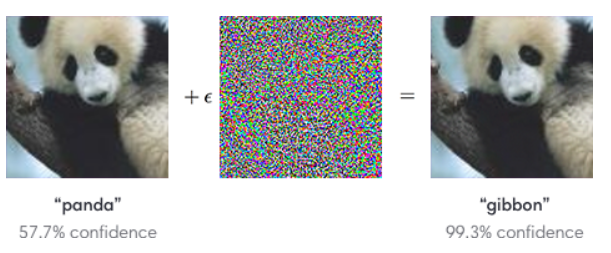

 In this setting, we often define imperceptibility, i.e., the attacker budget, as some neighborhood of the input image. For example, assuming the input image $x$ has pixel values in $[0,1]$, we might look for adversarial attacks inside the $l_\infty$ ball of radius $0.1$, i.e., *adversarial inputs* $x'$ s.t. $||x-x'||_\infty < 0.1$ on which the network makes a mistake.

Unsuprisingly, this extends to various other domains (language, sound, etc.), as well as graphs -- tweaking the features of a node or adding/removing an edge can easily confuse a GNN model:

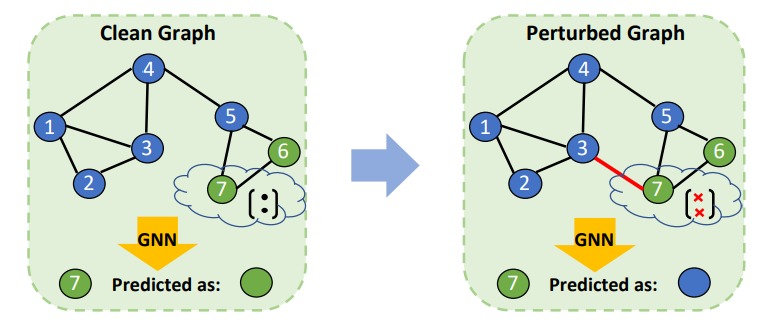

However, there are several challenges specific to graphs that make adversarial attacks and defenses interesting for GNNs: 

1. **The graphs are discrete** -- as pixel values are continuous, perturbing them almost always leads to a valid input image. However, perturbing adjacency matrices is more involved as they need to remain discrete, which also makes gradient-based methods significantly harder to directly apply.

2. **The nodes in the graph are not independent** -- by the nature of GNNs, perturbing the features of one node might affect the prediction of another. This led to new notions such as *influencer attacks* where we attempt to make a GNN misclassify a node without directly manipulating it in any way.

3. **It is difficult to define imperceptibility** -- while in images this comes naturally and can be easily formalized by thinking about $l_\infty$ or $l_2$ neighborhoods, it is unclear how this generalizes to graphs. Various definitions have been proposed (e.g., the attack should preserve some graph properties such as the degree distribution), but also used to craft *graph purification* procedures.

These unique challenges lead to a very active research field: follow [this repo](https://github.com/safe-graph/graph-adversarial-learning-literature) for most recent papers. I also recommend [DeepRobust](https://github.com/DSE-MSU/DeepRobust), which offers implementations of various attack/defense papers. 